# Capstone Project - Movie Recommendations for New Users
*Catherine Hocknell* | 10 April, 2023

##### Notebook 3/5

This notebook will contain all the methodology behind carrying out a Sentiment Analysis of the text reviews that are available within the *Reviews* dataset, looking specifically at those that have already been tokenised within the *NLP Processing* notebook.

The notebook will go through the process steps of dividing the dataset into training and testing sets, applying multiple vectorisation techniques, then carrying out multiple classification models on this data in order to find the most accurate method of predicting whether a review is classified as 'Rotten' or 'Fresh'.

---
# Sentiment Analysis

In [139]:
#import all necessary packages

import numpy as np
import pandas as pd

#graphing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from PIL import Image

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# scoring
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# optimisation
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import set_config
set_config(display='diagram')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# exporting pipelines
from sklearn.pipeline import make_pipeline
import joblib

# 0 Data Import

The data required for this notebook is contained within the following .csv file:

|Filename|Description|
|-|-|
|reviews_for_vectorizing_full.csv|Final reviews dataset including only english reviews with a numeric score after NLP pre-processing|

The file is imported and assigned to a dataframe below.

In [88]:
# import cleaned reviews df
final_df = pd.read_csv('data/reviews_for_vectorizing_full.csv', index_col = 0)

#sanity check
final_df.head(1)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,num,denom,final_score,review_length,stemmed,stem_str,review_type_calc
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),1,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,3.5,5,0.7,37,"['whether', 'audienc', 'get', 'behind', 'light...",whether audienc get behind lightn thief hard p...,1


# 1 Exploratory Data Analysis (EDA)
The output from the NLP pre-processing stage has been imported into this notebook as `final_df`. The content of this file is investigated below, looking at the size and content.

In [3]:
# describe shape
print(f'The dataframe has {final_df.shape[0]} rows and {final_df.shape[1]} columns.')

The dataframe has 541937 rows and 15 columns.


In [4]:
# review contents
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541937 entries, 3 to 1130015
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  541937 non-null  object 
 1   critic_name           541937 non-null  object 
 2   top_critic            541937 non-null  bool   
 3   publisher_name        541937 non-null  object 
 4   review_type           541937 non-null  int64  
 5   review_score          541937 non-null  object 
 6   review_date           541937 non-null  object 
 7   review_content        541937 non-null  object 
 8   num                   541937 non-null  float64
 9   denom                 541937 non-null  int64  
 10  final_score           541937 non-null  float64
 11  review_length         541937 non-null  int64  
 12  stemmed               541937 non-null  object 
 13  stem_str              541919 non-null  object 
 14  review_type_calc      541937 non-null  int64  
dtyp

The above output shows that there are null values within the `stem_str` column, which where not indicated in the previous notebook. These are investigated below.

In [5]:
# look at top two null values
final_df[final_df['stem_str'].isna()].head(2)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,num,denom,final_score,review_length,stemmed,stem_str,review_type_calc
22842,m/1013004-made_in_heaven,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",0,2/5,2002-11-05,"No, it wasn't.",2.0,5,0.4,3,[],NaN,0
34831,m/1066712-to_die_for,Christopher Null,False,Filmcritic.com,0,3/5,2001-06-27,That was it?,3.0,5,0.6,3,[],NaN,0


The above table shows that there are some reviews which, once text processing has been carried out, now have no content. This is likely due to all the text content within them being within the *stopwords* list used previously, which seems to be the case for the above two examples (i.e. That was it?). All these will be removed as they will cause issues when running the vectoriser.

In [6]:
# drop null values
final_df.dropna(inplace = True)

In [7]:
# sanity check for null values
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541919 entries, 3 to 1130015
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  541919 non-null  object 
 1   critic_name           541919 non-null  object 
 2   top_critic            541919 non-null  bool   
 3   publisher_name        541919 non-null  object 
 4   review_type           541919 non-null  int64  
 5   review_score          541919 non-null  object 
 6   review_date           541919 non-null  object 
 7   review_content        541919 non-null  object 
 8   num                   541919 non-null  float64
 9   denom                 541919 non-null  int64  
 10  final_score           541919 non-null  float64
 11  review_length         541919 non-null  int64  
 12  stemmed               541919 non-null  object 
 13  stem_str              541919 non-null  object 
 14  review_type_calc      541919 non-null  int64  
dtyp

In [8]:
# review statistic information for numeric columns
final_df.describe()

,review_type,num,denom,final_score,review_length,review_type_calc
count,541919.000000,541919.000000,541919.000000,541919.000000,541919.000000,541919.000000
mean,0.639828,3.258315,5.127122,0.634374,21.476606,0.468112
std,0.480051,1.604388,1.733935,0.210262,9.199944,0.498983
min,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000
25%,0.000000,2.000000,4.000000,0.500000,15.000000,0.000000
50%,1.000000,3.000000,5.000000,0.625000,21.000000,0.000000
75%,1.000000,4.000000,5.000000,0.800000,28.000000,1.000000
max,1.000000,10.000000,10.000000,1.000000,55.000000,1.000000


In [9]:
# describe shape
print(f'The cleaned dataframe has {final_df.shape[0]} rows and {final_df.shape[1]} columns.')

The cleaned dataframe has 541919 rows and 15 columns.


It is also useful here to have a reminder of the balance of values within each of the possible target variables, which in this case will be `review_type` for the Sentiment Analysis, with `final_score` also potentially being reviewed later as part of a regression analysis. The plots for each of these variables are given below.

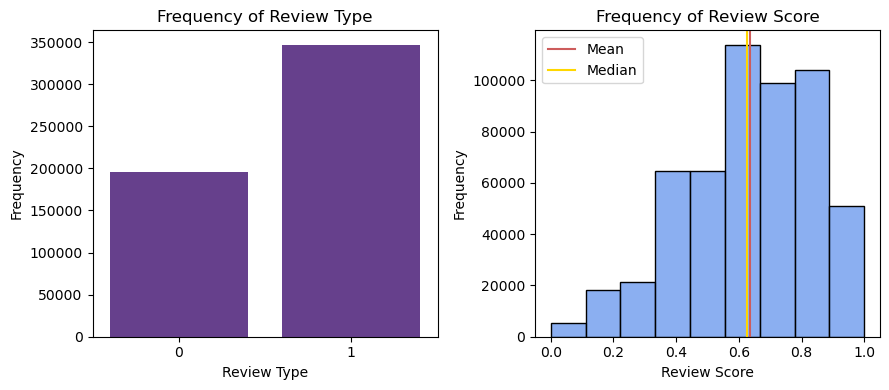

In [10]:
# generate subplots
plt.subplots(1,2, figsize = (9,4))

plt.subplot(1,2,1)
# barplot for categorical variables
sns.countplot(x = final_df['review_type'], color = 'rebeccapurple')
#labels
plt.title('Frequency of Review Type')
plt.xlabel('Review Type')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
# barplot for categorical variables
sns.histplot(x = final_df['final_score'],bins = 9, color = 'cornflowerblue')
plt.axvline(final_df['final_score'].mean(), color = 'indianred', label = 'Mean')
plt.axvline(final_df['final_score'].median(), color = 'gold', label = 'Median')
#labels
plt.title('Frequency of Review Score')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()

plt.show()

In [11]:
# calculate percentage distribution of review type
values, counts = np.unique(final_df['review_type'], return_counts=True)
normalized_counts = counts/counts.sum()
print(f"Review Type Class Imbalance: {np.round(normalized_counts, 2)}")

Review Type Class Imbalance: [0.36 0.64]


The above graphs show that there is class imbalance within the `review_type` column, which indicates that there may be bias towards the positive ('Fresh') reviews when carrying out the sentiment analysis. This is also the case for the `final_score` continuous target variable, which although following a partially normal distribution, has a slight left skew.

# 2 Splitting the Data
In order to carry out Sentiment Analysis, first the dataset must be split into the testing and training set to be used to evaluate all the possible models. A validation set will also be created during this stage, which will be used to tune the hyperparameters of each of the models to be used in order to result in the best possible accuracy for each one.

## 2.1 Dependent and Independent Variables
The first stage in splitting the data is to divide out the dependent/target variables (y) and independent variables (X). For the case of Sentiment Analysis, the **independent variable** is the column containing the **tokenised review text data**, and the **target variables** are the possible **review types**. These have been defined below.

In [12]:
# drop all possible target variables
X = final_df.drop(columns = ['review_type','final_score','review_type_calc'])

# various options to be used
y = final_df[['review_type','final_score','review_type_calc']]

It should be noted that the independent variables X have also included the other remaining columns, incase these will be included later on in any future analysis.

In [13]:
# sanity check
y.head()

,review_type,final_score,review_type_calc
3,1,0.70,1
6,0,0.25,0
7,1,0.70,1
9,1,0.60,0
10,1,0.80,1


## 2.2 Test/Train/Validation Split
The second stage is to separate both the X and y variables into a testing, training and validation set. This is done in two stages, as detailed below.

### 2.2.1 Test/Remainder Split

First, the entire `final_df` dataset is split into a *test* set and a *remainder* set. A 30% test split is defined here, as there is a very high number of rows within the dataset to be considered. A random state has been defined in order to allow for reproducibility.

In [14]:
# defining the split in X and y
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = y['review_type'])

In [15]:
#Sanity check - X
print(f'The remainder dataset for X has {X_remainder.shape[0]} rows and {X_remainder.shape[1]} columns.')
print(f'The test dataset for X has {X_test.shape[0]} rows and {X_test.shape[1]} columns.')

The remainder dataset for X has 379343 rows and 12 columns.
The test dataset for X has 162576 rows and 12 columns.


In [16]:
#Sanity check - y
print(f'The remainder dataset for y has {y_remainder.shape[0]} rows and {y_remainder.shape[1]} columns.')
print(f'The test dataset for y has {y_test.shape[0]} rows and {y_test.shape[1]} columns.')

The remainder dataset for y has 379343 rows and 3 columns.
The test dataset for y has 162576 rows and 3 columns.


### 2.2.2 Train/Validation Split
The *remainder* dataset is then split further into a *training* set and *validation* set, which will be used to optimise the model hyperparameters. This is carried out below, where a 20% validation split and random state has been defined.

In [17]:
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size=0.2, random_state=123, stratify = y_remainder['review_type'])

In [18]:
#Sanity check - X
print(f'The training dataset for X has {X_train.shape[0]} rows and {X_train.shape[1]} columns.')
print(f'The validation dataset for X has {X_validation.shape[0]} rows and {X_validation.shape[1]} columns.')

The training dataset for X has 303474 rows and 12 columns.
The validation dataset for X has 75869 rows and 12 columns.


In [19]:
#Sanity check - y
print(f'The training dataset for y has {y_train.shape[0]} rows and {y_train.shape[1]} columns.')
print(f'The validation dataset for y has {y_validation.shape[0]} rows and {y_validation.shape[1]} columns.')

The training dataset for y has 303474 rows and 3 columns.
The validation dataset for y has 75869 rows and 3 columns.


## 2.3 Define X and y for Sentiment Analysis
The final stage is to now define each of the possible X and y variables by which to carry out the Sentiment analysis (and future regression model). In this case, these are defined as the following:

|Type|Definition|Column Name|Use-Case|
|-|-|-|-|
|Independent Variable |X|`stem_str`|To be Vectorised for all cases|
|Target Variable |y_1|`review_type`|Sentiment Analysis (unbalanced)|
|Target Variable |y_2|`review_type_calc`|Sentiment Analysis (balanced)|
|Target Variable| y_3|`final_score`|Regression Model|

These variables are generated below.

In [20]:
# remainder X
reviews_remainder = X_remainder['stem_str']

# train X
reviews_train = X_train['stem_str']

# validation X
reviews_validation = X_validation['stem_str']

# test X
reviews_test = X_test['stem_str']

# sanity check
reviews_test.head(1)

960587    challeng america 's welfar system give impecc ...
Name: stem_str, dtype: object

In [21]:
# y options = 'review_type','final_score','review_type_calc'

# assign y  remainder values
y_remainder_1 = y_remainder['review_type']
y_remainder_2 = y_remainder['review_type_calc']
y_remainder_3 = y_remainder['final_score']

# assign y  train values
y_train_1 = y_train['review_type']
y_train_2 = y_train['review_type_calc']
y_train_3 = y_train['final_score']

# assign y validation values
y_validation_1 = y_validation['review_type']
y_validation_2 = y_validation['review_type_calc']
y_validation_3 = y_validation['final_score']

# assign y test values
y_test_1 = y_test['review_type']
y_test_2 = y_test['review_type_calc']
y_test_3 = y_test['final_score']

# sanity check
y_test_1.head(1)

960587    1
Name: review_type, dtype: int64

# 3 Balancing the Data
The previously shown graphs of the distribution of the target variable shows that there is an inbalance in the target variable `review_type`. Due to there being a large number of rows available within the dataset in this case, downsampling of the training set can be investigated in order to see how this will impact the accuracy results. In order to do this, the **Class 1** reviews will be **downsampled** to be equal to class 0. This will be carried out for the train set and remainder set, as both will be used within this notebook to generate optimal models.

## 3.1 Train Set

In [22]:
print('Number of class 1 examples before:', reviews_train[y_train_1 == 1].shape[0])
print('Number of class 0 examples before:', reviews_train[y_train_1 == 0].shape[0])

Number of class 1 examples before: 194171
Number of class 0 examples before: 109303


In [23]:
from sklearn.utils import resample

In [24]:
# Downsample

reviews_train_down, y_train_down_1 = resample(reviews_train[y_train_1 == 1], 
                                        y_train_1[y_train_1 == 1], 
                                        replace=True, 
                                        n_samples=reviews_train[y_train_1 == 0].shape[0], 
                                        random_state=123)

print('Number of class 1 examples after:', reviews_train_down.shape[0])


Number of class 1 examples after: 109303


In [25]:
# Combine downsampled class 1 with original data class 0
reviews_train_bal = np.hstack((reviews_train[y_train_1 == 0], reviews_train_down))
y_train_bal_1 = np.hstack((y_train_1[y_train_1 == 0], y_train_down_1))

# Convert the X variable numpy array into a dataframe
reviews_train_bal = pd.DataFrame(reviews_train_bal)

# sanity check
reviews_train_bal.head(1)

,0
0,lee schamu make histori blandli palat process ...


## 3.2 Remainder Set

In [26]:
print('Number of class 1 examples before:', reviews_remainder[y_remainder_1 == 1].shape[0])
print('Number of class 0 examples before:', reviews_remainder[y_remainder_1 == 0].shape[0])

Number of class 1 examples before: 242714
Number of class 0 examples before: 136629


In [27]:
# Downsample

reviews_remainder_down, y_remainder_down_1 = resample(reviews_remainder[y_remainder_1 == 1], 
                                            y_remainder_1[y_remainder_1 == 1], 
                                            replace=True, 
                                            n_samples=reviews_remainder[y_remainder_1 == 0].shape[0], 
                                            random_state=123)

print('Number of class 1 examples after:', reviews_remainder_down.shape[0])


Number of class 1 examples after: 136629


In [28]:
# Combine downsampled class 1 with original data class 0
reviews_remainder_bal = np.hstack((reviews_remainder[y_remainder_1 == 0], reviews_remainder_down))
y_remainder_bal_1 = np.hstack((y_remainder_1[y_remainder_1 == 0], y_remainder_down_1))

# Convert the X variable numpy array into a dataframe
reviews_remainder_bal = pd.DataFrame(reviews_remainder_bal)

# sanity check
reviews_remainder_bal.head(1)

,0
0,less partisan viewer may find film quit long l...


The remainder set will be used when carrying out model optimisation using a pipeline, therefore will not needed to be vectorised a this stage. The X variables for the remainder data are therefore defined below.

In [29]:
# define unbalanced X remainder
X_remainder = reviews_remainder

# define balanced X remainder
X_remainder_bal = reviews_remainder_bal[0]

# sanity check
X_remainder_bal.head(1)

0    less partisan viewer may find film quit long l...
Name: 0, dtype: object

# 4 NLP Vectorisation
There are two methods of NLP vectorisation that will be carried out in this section, both of which will be used throughout the remainder of this notebook in order to come up with the most accurate model. These are **Bag of Words** and **TF-IDF**, with the methods of each explained in the section below.

## 4.1 Bag of Words
Bag of Words is the most basic form of vectorisation, where the frequency of each word within the assigned input is simply counted and split between columns assigned to each token or word. There are a number of hyperparamaters to assign within a bag of words model, which have been defined as the following:

|Hyperparameter|Definition|Value|
|-|-|-|
|`min_df`|Minimum number of reviews the token must appear in to be counted|Minimum of 50|
|`ngram_range`|The number of tokens that can be considered in each ngram/column|Ngrams of one or two tokens|

The vectorisation is carried out below, for both the balanced and unbalanced data to see how the results compare. This is only carried out for the training, validation and test set in this occasion, as the remainder set will be vectorised when included within a pipeline.

### 4.1.1 Unbalanced Data

In [30]:
# 1. Instantiate
bagofwords = CountVectorizer(min_df=50, ngram_range=(1, 2))

# 2. Fit
bagofwords.fit(reviews_train)

# 3. Transform
# training set
X_train_transformed_bag = bagofwords.transform(reviews_train)

# validation set
X_validation_transformed_bag = bagofwords.transform(reviews_validation)

# test set
X_test_transformed_bag = bagofwords.transform(reviews_test)

# sanity check
X_test_transformed_bag

<162576x10630 sparse matrix of type '<class 'numpy.int64'>'
	with 2034855 stored elements in Compressed Sparse Row format>

In [31]:
# print sizes of the datasets
print(f'Training set: rows = {X_train_transformed_bag.shape[0]}, columns = {X_train_transformed_bag.shape[1]}')
print(f'Validation set: rows = {X_validation_transformed_bag.shape[0]}, columns = {X_validation_transformed_bag.shape[1]}')
print(f'Testing set: rows = {X_test_transformed_bag.shape[0]}, columns = {X_test_transformed_bag.shape[1]}')

Training set: rows = 303474, columns = 10630
Validation set: rows = 75869, columns = 10630
Testing set: rows = 162576, columns = 10630


The above shows that the *Bag of Words* vectoriser has divided the review text data into **10,630 ngrams**, and each of the X variables have been transformed accordingly. It should be noted that each of these X variables will now be in the form of a sparse matrix, which is the term given to a matrix of values consisting predominantly of zeros and are used in order to save memory.

### 4.1.2 Balanced Data

In [32]:
# 1. Instantiate
bagofwords_bal = CountVectorizer(min_df=50, ngram_range=(1, 2))

# 2. Fit
bagofwords_bal.fit(reviews_train_bal[0])

# 3. Transform
# training set
X_train_bal_bag = bagofwords_bal.transform(reviews_train_bal[0])

# validation set
X_validation_bal_bag = bagofwords_bal.transform(reviews_validation)

# test set
X_test_bal_bag = bagofwords_bal.transform(reviews_test)

# sanity check
X_test_bal_bag

<162576x7995 sparse matrix of type '<class 'numpy.int64'>'
	with 1950796 stored elements in Compressed Sparse Row format>

In [33]:
# print sizes of the datasets
print(f'Training set: rows = {X_train_bal_bag.shape[0]}, columns = {X_train_bal_bag.shape[1]}')
print(f'Validation set: rows = {X_validation_bal_bag.shape[0]}, columns = {X_validation_bal_bag.shape[1]}')
print(f'Testing set: rows = {X_test_bal_bag.shape[0]}, columns = {X_test_bal_bag.shape[1]}')

Training set: rows = 218606, columns = 7995
Validation set: rows = 75869, columns = 7995
Testing set: rows = 162576, columns = 7995


The above shows that the *Bag of Words* vectoriser has divided the review text data into **7,995 ngrams**, and each of the X variables have been transformed accordingly. As above, the X variables will be in the form of a sparse matrix.

## 4.2 TF-IDF
TF-IDF (term frequency-inverse document frequency) is another form of vectorisation, which instead of simply counting the tokens, a score is associated to each one depending on the frequency of it's occurence - both within the individual review (document), and the entire corpus of documents. The same hyperparameters are assigned as for the Bag of Words vectorisor, and vectorisation has been carried out below on both the unbalanced and balanced data.

### 4.2.1 Unbalanced Data

In [34]:
# 1. Instantiate
tfidf = TfidfVectorizer(min_df=50, ngram_range=(1, 2))

# 2. Fit
tfidf.fit(reviews_train)

# 3. Transform
# training set
X_train_transformed_tf = tfidf.transform(reviews_train)

# validation set
X_validation_transformed_tf = tfidf.transform(reviews_validation)

# test set
X_test_transformed_tf = tfidf.transform(reviews_test)

# sanity check
X_test_transformed_tf

<162576x10630 sparse matrix of type '<class 'numpy.float64'>'
	with 2034855 stored elements in Compressed Sparse Row format>

In [35]:
print(f'Training set: rows = {X_train_transformed_tf.shape[0]}, columns = {X_train_transformed_tf.shape[1]}')
print(f'Validation set: rows = {X_validation_transformed_tf.shape[0]}, columns = {X_validation_transformed_tf.shape[1]}')
print(f'Testing set: rows = {X_test_transformed_tf.shape[0]}, columns = {X_test_transformed_tf.shape[1]}')

Training set: rows = 303474, columns = 10630
Validation set: rows = 75869, columns = 10630
Testing set: rows = 162576, columns = 10630


The above shows that, similar to the *Bag of Words* model, the *TF-IDF* vectoriser has divided the review text data into **10,630 ngrams**, and each of the X variables have been transformed accordingly into a new set of sparse matrices.

### 4.2.2 Unbalanced Data

In [36]:
# 1. Instantiate
tfidf_bal = TfidfVectorizer(min_df=50, ngram_range=(1, 2))

# 2. Fit
tfidf_bal.fit(reviews_train_bal[0])

# 3. Transform
# training set
X_train_bal_tf = tfidf_bal.transform(reviews_train_bal[0])

# validation set
X_validation_bal_tf = tfidf_bal.transform(reviews_validation)

# test set
X_test_bal_tf = tfidf_bal.transform(reviews_test)

# sanity check
X_test_bal_tf

<162576x7995 sparse matrix of type '<class 'numpy.float64'>'
	with 1950796 stored elements in Compressed Sparse Row format>

In [38]:
print(f'Training set: rows = {X_train_bal_tf.shape[0]}, columns = {X_train_bal_tf.shape[1]}')
print(f'Validation set: rows = {X_validation_bal_tf.shape[0]}, columns = {X_validation_bal_tf.shape[1]}')
print(f'Testing set: rows = {X_test_bal_tf.shape[0]}, columns = {X_test_bal_tf.shape[1]}')

Training set: rows = 218606, columns = 7995
Validation set: rows = 75869, columns = 7995
Testing set: rows = 162576, columns = 7995


The above shows that, similar to the *Bag of Words* model, the *TF-IDF* vectoriser has divided the review text data into **7,995 ngrams**, and each of the X variables have been transformed accordingly into a new set of sparse matrices.

# 5 Classification Modelling
With the X and y variables now assigned, it is possible to carry out a number of different classification models in order to evaluate which is the best to be used within the Sentiment Analysis. The following options for classification models will be carried out, both on the bag of words and TF-IDF vectorised data.
- Logistic Regression
- Decision Tree
- SVM

After running these intial models, boosting and bagging methods will also be evaluated in order to ensure that the most accurate model has been chosen. For the classification model, the following boosting technique will be used:
- XGBoost

# 5.1 Logistic Regression
The first model to be evaluated is a Logistic Regression model. In order to run the most accurate model, first hyperparameter optimisation is carried out over each of the combinations of vectoriser and target variable balance.

### 5.1.1 Hyperparameter Optimisation
Hyperparameter optimisation is a method that utilises both the training and validation sets in order to find the model hyperparameters which result in the most accurate classification model. Both the Bag of Words and TF-IDF independent variables must be evaluated seperately, as they will contain different information.

#### 5.1.1.1 Bag of Words
First, the unbalanced Bag of Words model is run in order to find the optimal value for hyperparameter `C`, which is defined as being the strength of the lambda function.

In [34]:
# define empty lists for score data
validation_scores_bag = []
train_scores_bag = []

# define range of C values
C_range = np.array([.00001,.0001,.001,0.1,1,10,100,1000])

# fit and score model using each value of C defined above
for c in C_range:
    bag_logreg = LogisticRegression(C = c,random_state=123, max_iter = 10000)
    bag_logreg.fit(X_train_transformed_bag,y_train_1)
    print(f'Running model c = {c}...')
    
    # train on traning set
    train_scores_bag.append(bag_logreg.score(X_train_transformed_bag,y_train_1))
    # score on validation set
    validation_scores_bag.append(bag_logreg.score(X_validation_transformed_bag,y_validation_1))

Running model c = 1e-05...
Running model c = 0.0001...
Running model c = 0.001...
Running model c = 0.1...
Running model c = 1.0...
Running model c = 10.0...
Running model c = 100.0...
Running model c = 1000.0...


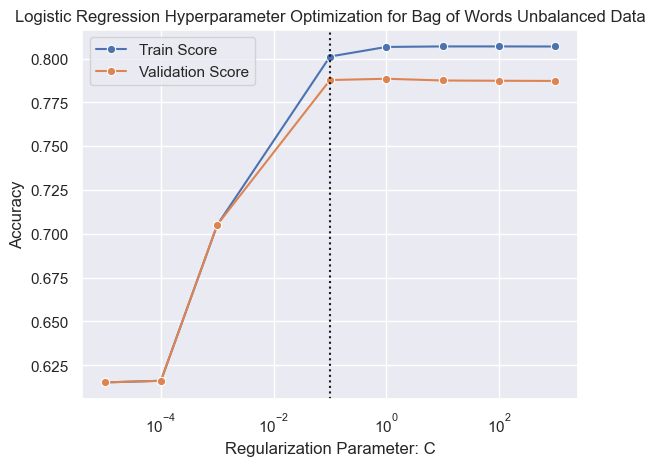

In [64]:
# df of scores for use in seaborn
train_logreg_bag = pd.DataFrame({'C':C_range, 'Score': train_scores_bag})
val_logreg_bag = pd.DataFrame({'C':C_range, 'Score': validation_scores_bag})

#plot graph
plt.figure()
sns.set(style='darkgrid')
sns.lineplot(data = train_logreg_bag, x = 'C', y = 'Score', marker = 'o', label = 'Train Score')
sns.lineplot(data = val_logreg_bag, x = 'C', y = 'Score', marker = 'o', label = 'Validation Score')

#labels
plt.title('Logistic Regression Hyperparameter Optimization for Bag of Words Unbalanced Data')
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Accuracy')

# line to show optimal C value
plt.axvline(0.1, color = 'k', linestyle = ':')
plt.show()

This shows that the optimal value for C is **0.1**. To see if this is changed when looking at the balanced training data, the process is repeated with the balanced bag of words data

In [36]:
validation_scores_bagbal = []
train_scores_bagbal = []

C_range = np.array([.00001,.0001,.001,0.1,1,10,100,1000])

for c in C_range:
    bagbal_logreg = LogisticRegression(solver = 'saga', C = c,random_state=123, max_iter = 10000)
    bagbal_logreg.fit(X_train_bal_bag,y_train_bal_1)
    print(f'Running model c = {c}...')
    
    # train on traning set
    train_scores_bagbal.append(bagbal_logreg.score(X_train_bal_bag,y_train_bal_1))
    # score on validation set
    validation_scores_bagbal.append(bagbal_logreg.score(X_validation_bal_bag,y_validation_1))

Running model c = 1e-05...
Running model c = 0.0001...
Running model c = 0.001...
Running model c = 0.1...
Running model c = 1.0...
Running model c = 10.0...
Running model c = 100.0...
Running model c = 1000.0...


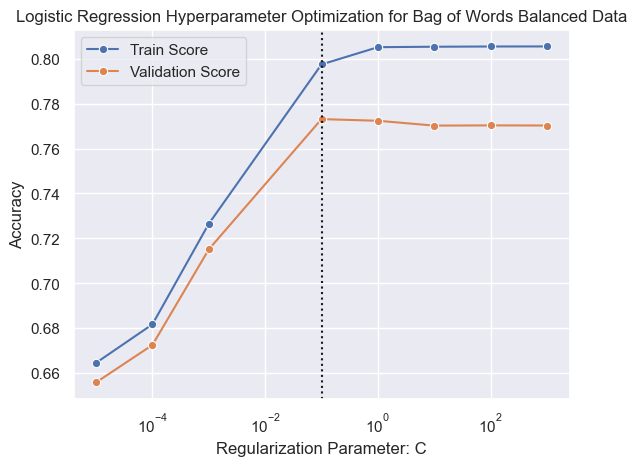

In [63]:
# df of scores for use in seaborn
train_logreg_bagbal = pd.DataFrame({'C':C_range, 'Score': train_scores_bagbal})
val_logreg_bagbal = pd.DataFrame({'C':C_range, 'Score': validation_scores_bagbal})

#plot graph
plt.figure()
sns.set(style='darkgrid')
sns.lineplot(data = train_logreg_bagbal, x = 'C', y = 'Score', marker = 'o', label = 'Train Score')
sns.lineplot(data = val_logreg_bagbal, x = 'C', y = 'Score', marker = 'o', label = 'Validation Score')

#labels
plt.title('Logistic Regression Hyperparameter Optimization for Bag of Words Balanced Data')
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Accuracy')

# line to show optimal C value
plt.axvline(0.1, color = 'k', linestyle = ':')
plt.show()

This shows that the optimal value for C remains at **0.1**. This will be used in an optimised logistic regression model later on to assess the accuracy of the test data analysis results.

#### 5.1.1.2 TF-IDF
In the same way, the `C` hyperparameter is also assessed for the TF-IDF model for both the unbalanced and balanced target variable. This is detailed below.

In [38]:
validation_scores_tf = []
train_scores_tf = []

C_range = np.array([.00001,.0001,.001,0.1,1,10,100,1000])

for c in C_range:
    tf_logreg = LogisticRegression(C = c,random_state=123, max_iter = 10000)
    tf_logreg.fit(X_train_transformed_tf,y_train_1)
    print(f'Running model c = {c}...')
    
    # train on traning set
    train_scores_tf.append(tf_logreg.score(X_train_transformed_tf,y_train_1))
    # score on validation set
    validation_scores_tf.append(tf_logreg.score(X_validation_transformed_tf,y_validation_1))

Running model c = 1e-05...
Running model c = 0.0001...
Running model c = 0.001...
Running model c = 0.1...
Running model c = 1.0...
Running model c = 10.0...
Running model c = 100.0...
Running model c = 1000.0...


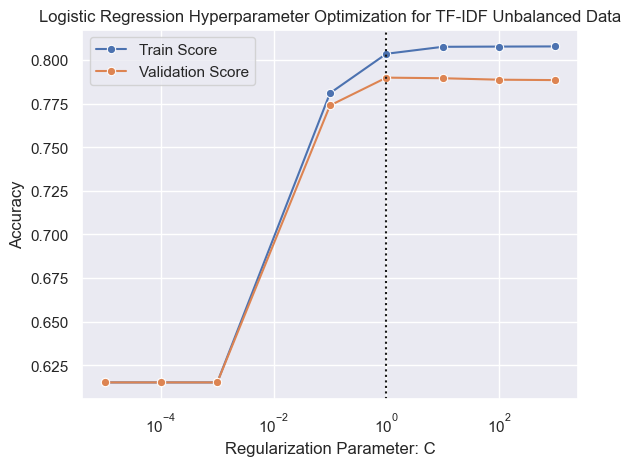

In [61]:
# df of scores for use in seaborn
train_logreg_tf = pd.DataFrame({'C':C_range, 'Score': train_scores_tf})
val_logreg_tf = pd.DataFrame({'C':C_range, 'Score': validation_scores_tf})

#plot graph
plt.figure()
sns.set(style='darkgrid')
sns.lineplot(data = train_logreg_tf, x = 'C', y = 'Score', marker = 'o', label = 'Train Score')
sns.lineplot(data = val_logreg_tf, x = 'C', y = 'Score', marker = 'o', label = 'Validation Score')

#labels
plt.title('Logistic Regression Hyperparameter Optimization for TF-IDF Unbalanced Data')
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Accuracy')

# line to show optimal C value
plt.axvline(1, color = 'k', linestyle = ':')
plt.show()

This shows that the optimal value for C is **1**, which is a change from the Bag of Words model. To see if this is changed when looking at the balanced training data, the process is repeated with the balanced bag of words data

In [40]:
validation_scores_tfbal = []
train_scores_tfbal = []

C_range = np.array([.00001,.0001,.001,0.1,1,10,100,1000])

for c in C_range:
    tfbal_logreg = LogisticRegression(solver = 'saga', C = c,random_state=123, max_iter = 10000)
    tfbal_logreg.fit(X_train_bal_tf,y_train_bal_1)
    print(f'Running model c = {c}...')
    
    # train on traning set
    train_scores_tfbal.append(tfbal_logreg.score(X_train_bal_tf,y_train_bal_1))
    # score on validation set
    validation_scores_tfbal.append(tfbal_logreg.score(X_validation_bal_tf,y_validation_1))

Running model c = 1e-05...
Running model c = 0.0001...
Running model c = 0.001...
Running model c = 0.1...
Running model c = 1.0...
Running model c = 10.0...
Running model c = 100.0...
Running model c = 1000.0...


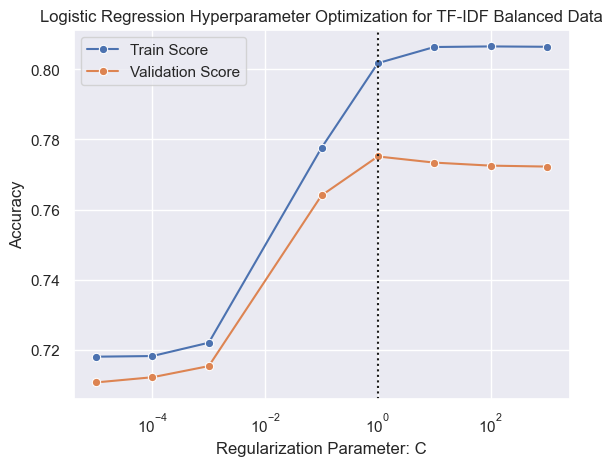

In [59]:
# df of scores for use in seaborn
train_logreg_tfbal = pd.DataFrame({'C':C_range, 'Score': train_scores_tfbal})
val_logreg_tfbal = pd.DataFrame({'C':C_range, 'Score': validation_scores_tfbal})

#plot graph
plt.figure()
sns.set(style='darkgrid')
sns.lineplot(data = train_logreg_tfbal, x = 'C', y = 'Score', marker = 'o', label = 'Train Score')
sns.lineplot(data = val_logreg_tfbal, x = 'C', y = 'Score', marker = 'o', label = 'Validation Score')

#labels
plt.title('Logistic Regression Hyperparameter Optimization for TF-IDF Balanced Data')
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Accuracy')

# line to show optimal C value
plt.axvline(1, color = 'k', linestyle = ':')
plt.show()

This shows that the optimal value for C remains at **1**. As with the bag of words model, this will be used in the next section of this report to assess the accuracy of the analysis of the test data.

### 5.1.2 Optimised Models
A final optimised model can now be run using the hyperparameters detailed in the previous section for each of the logistic regression models previously carried out.

#### 5.1.2.1 Bag of Words
First, the Bag of Words model is run using both the unbalanced and balanced data. The results of these analyses are detailed below.

In [85]:
#Unbalanced
# Random seed for reproducibility
np.random.seed(123)

# Fitting a model
bag_logreg = LogisticRegression(C = 0.1, max_iter = 10000)
bag_logreg.fit(X_train_transformed_bag, y_train_1)

# predictions
y_pred_test = bag_logreg.predict(X_test_transformed_bag)
report_init = classification_report(y_test_1, y_pred_test)
y_proba_test = bag_logreg.predict_proba(X_test_transformed_bag)[:,1]

# Training and test score
print(f"Unbalanced Data Bag of Words Train score: {bag_logreg.score(X_train_transformed_bag, y_train_1)}")
print(f"Unbalanced Data Bag of Words Test score: {bag_logreg.score(X_test_transformed_bag, y_test_1)}")

Unbalanced Data Bag of Words Train score: 0.8096377284380211
Unbalanced Data Bag of Words Test score: 0.7966428009054227


In [86]:
# balanced
# Random seed for reproducibility
np.random.seed(123)

# Fitting a model
bag_logreg_bal = LogisticRegression(C = 0.1, max_iter = 10000)
bag_logreg_bal.fit(X_train_bal_bag, y_train_bal_1)

# predictions
y_pred_test_bal = bag_logreg_bal.predict(X_test_bal_bag)
report_down = classification_report(y_test_1, y_pred_test_bal)
y_proba_test_bal = bag_logreg_bal.predict_proba(X_test_bal_bag)[:,1]

# Training and test score
print(f"Balanced Data Bag of Words Train score: {bag_logreg_bal.score(X_train_bal_bag, y_train_bal_1)}")
print(f"Balanced Data Bag of Words Test score: {bag_logreg_bal.score(X_test_bal_bag, y_test_1)}")

Balanced Data Bag of Words Train score: 0.8031389806318217
Balanced Data Bag of Words Test score: 0.7776178525735656


The above indicates that there is little difference in the test accuracy score between the balanced and unbalanced data for the Bag of Words model, with the unbalanced data providing a slightly higher accuracy of **79.7%**. This will be evaluated in more detail alongside the results from the TF-IDF vectorisation below.

#### 5.1.2.2 TF-IDF
The test accuracy scores for the TF-IDF vectorisation on both the balanced and unbalanced data is shown below.

In [39]:
# unbalanced
# Random seed for reproducibility
np.random.seed(123)

# Fitting a model
tf_logreg = LogisticRegression(C = 1, max_iter = 10000)
tf_logreg.fit(X_train_transformed_tf, y_train_1)

# predictions
y_pred_test_tf = tf_logreg.predict(X_test_transformed_tf)
report_init_tf = classification_report(y_test_1, y_pred_test_tf)
y_proba_test_tf = tf_logreg.predict_proba(X_test_transformed_tf)[:,1]

# Training and test score
print(f"Unbalanced Data TF-IDF Train score: {tf_logreg.score(X_train_transformed_tf, y_train_1)}")
print(f"Unbalanced Data TF-IDF Test score: {tf_logreg.score(X_test_transformed_tf, y_test_1)}")

Unbalanced Data TF-IDF Train score: 0.8124122659601811
Unbalanced Data TF-IDF Test score: 0.7981866942230096


In [88]:
# balanced
# Random seed for reproducibility
np.random.seed(123)

# Fitting a model
tf_logreg_bal = LogisticRegression(C = 1, max_iter = 10000)
tf_logreg_bal.fit(X_train_bal_tf, y_train_bal_1)

# predictions
y_pred_test_bal_tf = tf_logreg_bal.predict(X_test_bal_tf)
report_down_tf = classification_report(y_test_1, y_pred_test_bal_tf)
y_proba_test_bal_tf = tf_logreg_bal.predict_proba(X_test_bal_tf)[:,1]

# Training and test score
print(f"Balanced Data TF-IDF Train score: {tf_logreg_bal.score(X_train_bal_tf, y_train_bal_1)}")
print(f"Balanced Data TF-IDF Test score: {tf_logreg_bal.score(X_test_bal_tf, y_test_1)}")

Balanced Data TF-IDF Train score: 0.8067024692826363
Balanced Data TF-IDF Test score: 0.7799183151264639


As above, the unbalanced data provides a slightly higher test accuracy than the balanced accuracy score at **79.8%**. Comparison of each of the test accuracy scores is shown in the table below.

|Vectoriser|Balanced Test Accuracy|Unbalanced Test Accuracy|
|-|-|-|
|Bag of Words|77.76%|79.66%|
|TF-IDF|77.99%|79.81%|

The accuracy metrics will be evaluated in more detail below.

### 5.1.3 Model Evaluation
The four model variations will now be evaluated in more detail, specifically looking at their precision and recall scores, which are the measures by which the model is accurately predicting each class in terms of **True Positives** and **True Negatives**. The confusion matrix for each model is shown below, alongside the classification report in each case.

Bag of Words Confusion Matrices: 



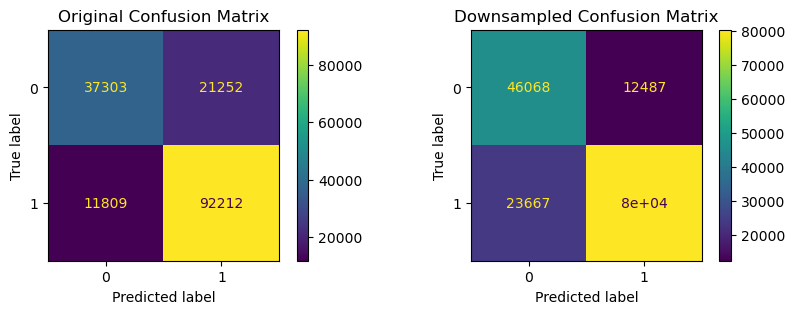

TF-IDF Confusion Matrices: 



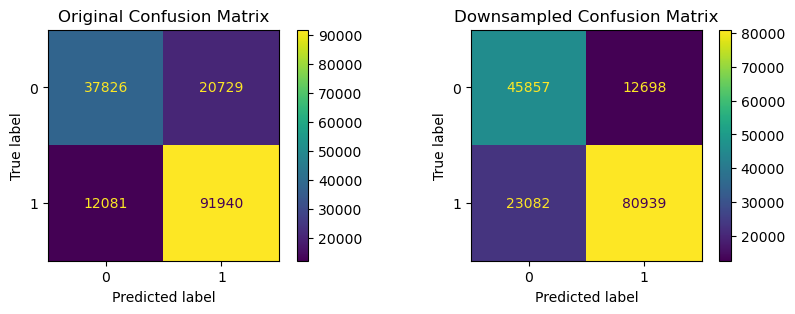


Original data classification report: 
               precision    recall  f1-score   support

           0       0.76      0.64      0.69     58555
           1       0.81      0.89      0.85    104021

    accuracy                           0.80    162576
   macro avg       0.79      0.76      0.77    162576
weighted avg       0.79      0.80      0.79    162576

Downsampled data classification report: 
               precision    recall  f1-score   support

           0       0.66      0.79      0.72     58555
           1       0.87      0.77      0.82    104021

    accuracy                           0.78    162576
   macro avg       0.76      0.78      0.77    162576
weighted avg       0.79      0.78      0.78    162576


Original TF-IDF classification report: 
               precision    recall  f1-score   support

           0       0.76      0.65      0.70     58555
           1       0.82      0.88      0.85    104021

    accuracy                           0.80    162576
   m

In [89]:
print_line = "\n=======================================================\n"

# Confusion matrices
print("Bag of Words Confusion Matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
ConfusionMatrixDisplay.from_estimator(bag_logreg, X_test_transformed_bag, y_test_1, ax=axes[0])
axes[0].set_title('Original Confusion Matrix')

# Model on the upsampled data
ConfusionMatrixDisplay.from_estimator(bag_logreg_bal, X_test_bal_bag, y_test_1, ax=axes[1])
axes[1].set_title('Downsampled Confusion Matrix')

plt.show()


# Confusion matrices
print("TF-IDF Confusion Matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
ConfusionMatrixDisplay.from_estimator(tf_logreg, X_test_transformed_tf, y_test_1, ax=axes[0])
axes[0].set_title('Original Confusion Matrix')

# Model on the upsampled data
ConfusionMatrixDisplay.from_estimator(tf_logreg_bal, X_test_bal_tf, y_test_1, ax=axes[1])
axes[1].set_title('Downsampled Confusion Matrix')

plt.show()

# Classification Reports
print("\nOriginal data classification report:", print_line, report_init)
print("Downsampled data classification report:", print_line, report_down)
print("\nOriginal TF-IDF classification report:", print_line, report_init_tf)
print("Downsampled TF-IDF classification report:", print_line, report_down_tf)

The above output is showing the following:
- There is minimal difference between the precision, accuracy and f1 scores between the two vectorisers.
- The unbalanced data results in high precision in both classes (up to 82%) and high recall for 'Fresh' reviews (88% for class 1) however has lower recall for 'Rotten' reviews (64% for class 0)
    - This indicates that whereas up to 82% of both Rotten and Fresh reviews predicted by the model were defined as Rotten and Fresh within the data (precision), only 64% of all the 'Rotten' reviews within the model were prediced to be 'Rotten' (recall).
    - This indicates that the model predicts both a high number of True Positives and False Positives, likely due to the excess of 'Fresh' reviews within the data.
- On the other hand, the balanced data results in high recall in both classes (up to 79%) and high precision for 'Fresh' reviews (up to 87% for class 1) however has lower precision for 'Rotten' reviews (66% for class 0)
    - This indicates that whereas up to 79% of all Rotten and Fresh reviews with the data were predicted accurately by the model (recall), only 66% of all the 'Rotten' reviews predicted by the model were defined as 'Rotten' within the data (precision).
    - This indicates that the model predicts both a high number of True Positives and False Negatives, meaning it is not accurately predicting the 'Fresh' reviews.

These relationships can be seen in more detail by plotting a *Receiver Operating Characteristic* (ROC) curve, which is a measure of the comparison of true positive and false positive rates. This is shown below.

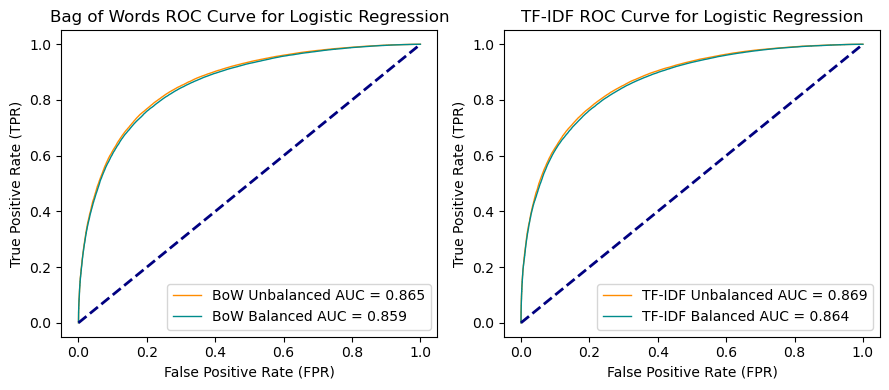

In [90]:
# define metrics for roc curves from sklearn
# bow unbalanced
fprs_bow, tprs_bow, thresholds_bow = roc_curve(y_test_1, y_proba_test)
roc_auc_bow = roc_auc_score(y_test_1, y_proba_test)

# bow balanced
fprs_bow_bal, tprs_bow_bal, thresholds_bow_bal = roc_curve(y_test_1, y_proba_test_bal)
roc_auc_bow_bal = roc_auc_score(y_test_1, y_proba_test_bal)

# tfidf unbalanced
fprs_tf, tprs_tf, thresholds_tf = roc_curve(y_test_1, y_proba_test_tf)
roc_auc_tf = roc_auc_score(y_test_1, y_proba_test_tf)

# ifidf balanced
fprs_tf_bal, tprs_tf_bal, thresholds_tf_bal = roc_curve(y_test_1, y_proba_test_bal_tf)
roc_auc_tf_bal = roc_auc_score(y_test_1, y_proba_test_bal_tf)


#plot roc curves
plt.subplots(1,2, figsize = (9,4))

#BoW plot
plt.subplot(1,2,1)
#line for original model
plt.plot(fprs_bow, tprs_bow, color='darkorange',
         lw=1, label='BoW Unbalanced AUC = %0.3f' % roc_auc_bow)
# line for feature engineered model
plt.plot(fprs_bow_bal, tprs_bow_bal, color='darkcyan',
         lw=1, label='BoW Balanced AUC = %0.3f' % roc_auc_bow_bal)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Bag of Words ROC Curve for Logistic Regression')
plt.legend(loc="best")

# TF-IDF plot
plt.subplot(1,2,2)
#line for original model
plt.plot(fprs_tf, tprs_tf, color='darkorange',
         lw=1, label='TF-IDF Unbalanced AUC = %0.3f' % roc_auc_tf)
# line for feature engineered model
plt.plot(fprs_tf_bal, tprs_tf_bal, color='darkcyan',
         lw=1, label='TF-IDF Balanced AUC = %0.3f' % roc_auc_tf_bal)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('TF-IDF ROC Curve for Logistic Regression')
plt.legend(loc="best")

plt.tight_layout()
plt.show()

The above graphs contain the calculate for the *Area Under Curve* (AUC) score for each of the four possible models, with the **Unbalanced TF-IDF** model having the highest score of **86.9%**. The AUC is the probability that when the model is given one point from each class, in this case 'Rotten' or 'Fresh', the model is *86.9%* more confident that the 'Fresh' review will be classified as 'Fresh' over the 'Rotten' review being classified as 'Fresh', and is considered to be one of the best measures of the quality of a model, particularly in this case when there is minimal negative impact from focussing on either precision or recall. For this purpose, only the TF-IDF unbalanced data will be taken forward to analyse the remaining classification models.

## 5.2 Decision Tree
The second model to be evaluated will be a decision tree model, where the hyperparameters will be tuned first in order to find the best model. In this case, only the TF-IDF balanced data will be evaluated in order to minimise the repetition of modelling.

### 5.2.1 Hyperparameter Optimisation
A decision tree model has a number of hyperparameters, so cannot be evaluated purely using the train/validation split method shown previously. That said, an initial investigation into the `max_depth` hyperparameter is carried out below, in order to narrow down the range to be assessed fully later on.

In [43]:
# define range for max depths and empty lists for results
depths = range(5, 61, 5)
validation_scores_DT = []
train_scores_DT = []

for d in depths:
    #fit DT model for all depths to be assessed
    DT = DecisionTreeClassifier(max_depth = d)
    # fit to training set scaled after validation split
    DT.fit(X_train_transformed_tf,y_train_1)
    #show progress of loop
    print(f"Working on d={d:.2f}...", end="\r")
    
    # train on traning set
    train_scores_DT.append(DT.score(X_train_transformed_tf,y_train_1))
    # score on validation set
    validation_scores_DT.append(DT.score(X_validation_transformed_tf,y_validation_1))

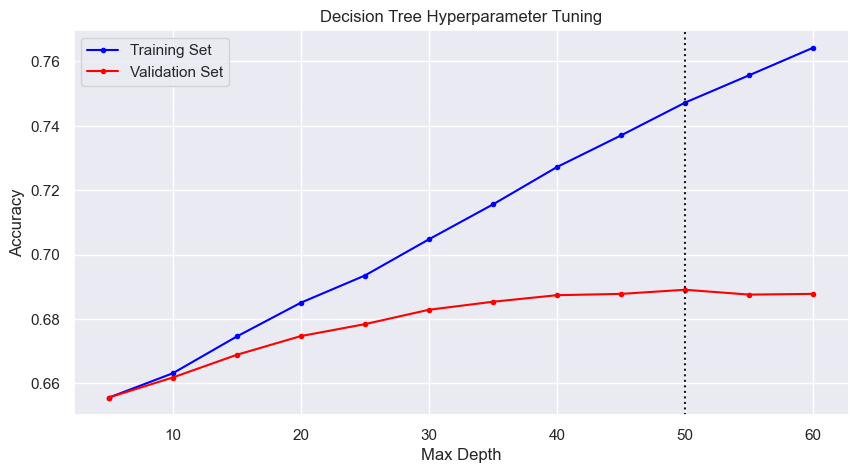

In [44]:
# plot graph to indicate best value for max_depth
plt.figure(figsize=(10, 5))
sns.set(style='darkgrid')

# plot accuracy scores for train and validation
plt.plot(depths, train_scores_DT, c='blue', label='Training Set', marker = '.')
plt.plot(depths, validation_scores_DT, c='red', label='Validation Set', marker = '.')

# line to define best max_depth value
plt.axvline(50, c = 'k', linestyle = ':')

#labels
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Hyperparameter Tuning")
plt.legend()
plt.show()

The above graph indicates that the accuracy of the validation set reaches its peak at around a `max_depth` of 50, at which point there is no further improvement. That said, the *Decision Tree* classification model has a number of other hyperparameters that should also be evaluated in order to come up with the most optimal model. 

This will be carried out below using a **Pipeline** with **Cross-Fold Validation**, where the vectoriser, model and hyperparameter options will be iterated in order to find the result with the highest test accuracy. The **unbalanced remainder dataset** is used as the input to this model, with the **TF-IDF** vectoriser assigned with the same input parameters as has been used previously.

In [112]:
# Create placeholders for both steps
estimatorsDT = [
    ('vectorise', TfidfVectorizer(min_df=40, ngram_range=(1, 2))), 
    ('model', DecisionTreeClassifier())
]

# define pipeline
DT_pipe = Pipeline(estimatorsDT)

In [114]:
param_gridDT = [
            {'vectorise': [TfidfVectorizer(min_df=40, ngram_range=(1, 2))],
             'model': [DecisionTreeClassifier()],
             'model__max_depth': [40, 60, 80],
             'model__min_samples_leaf': [2, 5, 10]}
               ]

gridDT = GridSearchCV(DT_pipe, param_gridDT, cv=3, verbose = 2)
fittedgridDT = gridDT.fit(X_remainder, y_remainder_1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END model=DecisionTreeClassifier(), model__max_depth=40, model__min_samples_leaf=2, vectorise=TfidfVectorizer(min_df=40, ngram_range=(1, 2)); total time= 1.2min
[CV] END model=DecisionTreeClassifier(), model__max_depth=40, model__min_samples_leaf=2, vectorise=TfidfVectorizer(min_df=40, ngram_range=(1, 2)); total time= 1.2min
[CV] END model=DecisionTreeClassifier(), model__max_depth=40, model__min_samples_leaf=2, vectorise=TfidfVectorizer(min_df=40, ngram_range=(1, 2)); total time= 1.1min
[CV] END model=DecisionTreeClassifier(), model__max_depth=40, model__min_samples_leaf=5, vectorise=TfidfVectorizer(min_df=40, ngram_range=(1, 2)); total time= 1.1min
[CV] END model=DecisionTreeClassifier(), model__max_depth=40, model__min_samples_leaf=5, vectorise=TfidfVectorizer(min_df=40, ngram_range=(1, 2)); total time= 1.3min
[CV] END model=DecisionTreeClassifier(), model__max_depth=40, model__min_samples_leaf=5, vectorise=TfidfVector

In [115]:
# output best parameters
fittedgridDT.best_params_

{'model': DecisionTreeClassifier(max_depth=60, min_samples_leaf=2),
 'model__max_depth': 60,
 'model__min_samples_leaf': 2,
 'vectorise': TfidfVectorizer(min_df=40, ngram_range=(1, 2))}

### 5.2.2 Model Evaluation
As with logistic regression, the precision, recall and AUC score is also calculated for the decision tree model using the optimal hyperparameters indicated above. These are evaluated by looking at the output of the best model from the Grid Search, and are calculated below.

In [117]:
# fit best predictor on un-vectorised test reviews 
y_pred_gridDT = fittedgridDT.predict(reviews_test)
y_proba_gridDT = fittedgridDT.predict_proba(reviews_test)[:,1]
roc_auc_DT = roc_auc_score(y_test_1, y_proba_gridDT)

In [120]:
# print accuracy of model
DT_test_sc2 = fittedgridDT.score(reviews_test, y_test_1)
print(f'Decision Tree Pipeline Accuracy: {fittedgridDT.best_score_:.3f}')
print(f'Decision Tree Test Accuracy: {DT_test_sc2:.3f}')

Decision Tree Pipeline Accuracy: 0.689
Decision Tree Test Accuracy: 0.691


In [119]:
# evaluate model
print(classification_report(y_test_1, y_pred_gridDT))
print(f'SVM AUC Score: {roc_auc_score(y_test_1, y_proba_gridDT):.3f}')

              precision    recall  f1-score   support

           0       0.63      0.35      0.45     58555
           1       0.71      0.89      0.79    104021

    accuracy                           0.69    162576
   macro avg       0.67      0.62      0.62    162576
weighted avg       0.68      0.69      0.66    162576

SVM AUC Score: 0.674


## 5.3 SVM
The final baseline model to be run before looking into possible boosting methods will be a *Support Vector Machine* (SVM) model, where the `C` hyperparameter is optimised below, using the train/validation split method used previously.

In [94]:
#graph the c value vs accuracy score to determine the optimal value. 

svm_train_acc = []
svm_val_acc = []
SVC_values = [10**i for i in range(-5, 1)] #c-value range is 10^-5 -> 10^+2

for A in SVC_values: 
    #initialize
    SVM = LinearSVC(C=A, max_iter=10000) #C= is the sklearn built-in parameter
    
    print(f"Working on C={A:}...", end="\r")
    
    #fit
    SVM.fit(X_train_bal_tf, y_train_bal_1)
    
    #score
    train_acc = SVM.score(X_train_bal_tf, y_train_bal_1)
    val_acc = SVM.score(X_validation_bal_tf, y_validation_1)
    
    #Append
    svm_train_acc.append(train_acc)
    svm_val_acc.append(val_acc)

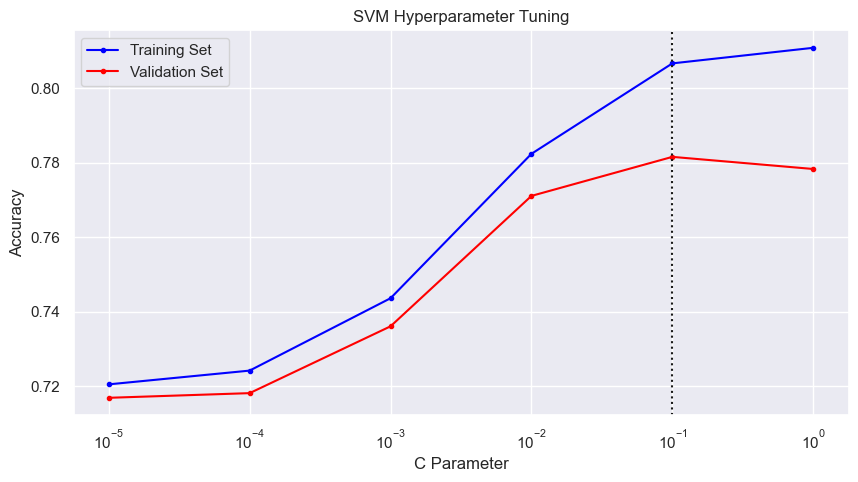

In [96]:
# plot graph to indicate best value for max_depth
plt.figure(figsize=(10, 5))
sns.set(style='darkgrid')

# plot accuracy scores for train and validation
plt.plot(SVC_values, svm_train_acc, c='blue', label='Training Set', marker = '.')
plt.plot(SVC_values, svm_val_acc, c='red', label='Validation Set', marker = '.')

# line to define best max_depth value
plt.axvline(0.1, c = 'k', linestyle = ':')

#labels
plt.xlabel("C Parameter")
plt.ylabel("Accuracy")
plt.title("SVM Hyperparameter Tuning")
plt.xscale('log')
plt.legend()
plt.show()

### 5.2.2 Model Evaluation
As with the previous models, the precision, recall and AUC score is calculated for the SVM model. These are evaluated and printed below. It should be noted that as the `LinearSVC` model does not include a built in function to predict the probabilities of the outputs (which is a required input for the AUC score) a **Calibrated Classifier** has also been used here in order to calculate the accuracy scores required to evaluate this model in comparison to the others that will be completed.

In [115]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [116]:
# Fitting a model
opt_SVM = LinearSVC(C=1, max_iter=10000)
clf = CalibratedClassifierCV(opt_SVM)
clf.fit(X_train_transformed_tf, y_train_1)

# calculate predictions
y_pred_optSVM = clf.predict(X_test_transformed_tf)
y_proba_optSVM = clf.predict_proba(X_test_transformed_tf)[:,1]

# Training and test score
print(f"Train score: {clf.score(X_train_transformed_tf, y_train_1):.3f}")
print(f"Test score: {clf.score(X_test_transformed_tf, y_test_1):.3f}")

Train score: 0.815
Test score: 0.797


In [118]:
print(classification_report(y_test_1, y_pred_optSVM))
print(f'SVM AUC Score: {roc_auc_score(y_test_1, y_proba_optSVM):.3f}')

              precision    recall  f1-score   support

           0       0.75      0.65      0.70     58555
           1       0.82      0.88      0.85    104021

    accuracy                           0.80    162576
   macro avg       0.78      0.76      0.77    162576
weighted avg       0.79      0.80      0.79    162576

SVM AUC Score: 0.868


## 5.4 Classification Model Evaluation
A number of variations of classification models have now been assessed with optimal hyperparameters. The results for each of these models are shown in the table below, looking only at the balanced TF-IDF vectorised data.

|Model|Test Accuracy|AUC Score|
|-|-|-|
|Logistic Regression|79.8%|0.869|
|Decision Tree|69.1%|0.674|
|SVM|79.7%|0.868|

The above table indicates that the **Logistic Regression** model is the most appropriate to use here, however before this decision is finalised boosting will be carried out to see if this can improve the result any further.

# 6 Boosting
Boosting is a method by which to improve a model by sequentially learning from the previous running of the model. There are many options for boosting of classification models, however in this case we will look only at **XGBoost**, which is a form of gradient booster.

## 6.1 XGBoost
XGBoost, or *Extreme Gradient Boosting* is a form of gradient boosting, which is when the algorithm fits each new model to the residuals of the previous model. In particular, XGBoost is considered to be one of the faster and more accurate gradient boosting methods, which is why it will be used here, and it has a number of hyperparameters that can be optimised through a pipeline. The hyperparameters that will be considered in this case are defined below, where some are related to those from the previous Decision Tree model due to the nature of the XGBoost method:

|Hyperparameter|Definition|
|-|-|
|`max_depth`|Maximum depth of a tree|
|`colsample_bytree`|Defines subsample of columns to be considered|
|`subsample`|Represents fraction of observations to be sampled for each tree|


These will be optimised through a pipeline, which will include the vectoriser (TF-IDF), booster and hyperparameters (similar to what has been shown previously for Decision Trees). The pipeline is defined below, then analysed over a variety of inputs for the hyperparameters mentioned above. In this case, a *Randomised Search* is used in order to minimise the computational expense of the evaluation.

In [40]:
# Create placeholders for both steps
estimatorsXG = [
    ('vectorise', TfidfVectorizer(min_df=40, ngram_range=(1, 2))), 
    ('model', XGBClassifier())
]

XG_pipe = Pipeline(estimatorsXG)

In [42]:
# define parameter options
param_randXG = [
            {'vectorise': [TfidfVectorizer(min_df=40, ngram_range=(1, 2))],
             'model': [XGBClassifier(random_state = 123, learning_rate = 0.1, n_estimators = 50)],
             'model__max_depth': [40, 60, 80],
             'model__colsample_bytree': [0.6, 0.8],
             'model__subsample': [0.5, 0.8, 1]}
               ]
# run 2 fold cross validation on 5 combinations of above grid to find best model
XGrand = RandomizedSearchCV(XG_pipe, param_randXG, cv=2, n_iter = 5, verbose = 2)
fittedrand_XG = XGrand.fit(X_remainder, y_remainder_1)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__colsample_bytree=0.6, model__max_depth=60, model__subsample=1, vectorise=TfidfVectorizer(min_df=40, ngram_range=(1, 2)); total time= 6.2min
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamm

*Note: the above has been run for only two folds and 5 hyperparemeter combinations in order to save on computing expense.*

The optimal results from the randomised search are printed and evaluated below.

In [43]:
# best model parameters
fittedrand_XG.best_params_

{'vectorise': TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
 'model__subsample': 0.5,
 'model__max_depth': 80,
 'model__colsample_bytree': 0.6,
 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=0.6, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.1, max_delta_step=None, max_depth=80,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=50, n_jobs=None, num_parallel_tree=None,
               random_state=123, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=0.5, tree_method=None,
               validate_parameters=None, verbosity=None)}

In [44]:
# fit best predictor on un-vectorised test reviews
y_pred_randXG = fittedrand_XG.predict(reviews_test)
y_proba_randXG = fittedrand_XG.predict_proba(reviews_test)[:,1]
roc_auc_randXG = roc_auc_score(y_test_1, y_proba_randXG)

In [46]:
# evaluate model accuracies
randXG_test_sc = fittedrand_XG.score(reviews_test, y_test_1)
print(f'XGBoost Pipeline Accuracy: {fittedrand_XG.best_score_:.3f}')
print(f'XGBoost Test Accuracy: {randXG_test_sc:.3f}')

XGBoost Test Accuracy: 0.757


In [50]:
# XGBoost AUC score
print(classification_report(y_test_1, y_pred_randXG))
print(f'XGBoost AUC Score: {roc_auc_score(y_test_1, y_proba_randXG):.3f}')

              precision    recall  f1-score   support

           0       0.76      0.48      0.59     58555
           1       0.76      0.91      0.83    104021

    accuracy                           0.76    162576
   macro avg       0.76      0.70      0.71    162576
weighted avg       0.76      0.76      0.74    162576

XGBoost AUC Score: 0.823


In [48]:
# evaluate all results
fittedrand_XG.cv_results_

{'mean_fit_time': array([301.90656567, 211.28842235, 244.16484416, 325.81055927,
        212.63934708]),
 'std_fit_time': array([49.17649508,  7.01044297,  1.39470017, 11.85253048,  0.62334538]),
 'mean_score_time': array([21.09425259, 13.20343649, 17.99473536, 16.77801323, 14.29176939]),
 'std_score_time': array([1.94863105, 0.01678884, 1.8854605 , 1.32425284, 0.3914367 ]),
 'param_vectorise': masked_array(data=[TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2))],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__subsample': masked_array(data=[1, 0.8, 0.5, 1, 0.5],
              mask=[False, False, False, False, False],
        fill_value='?',
      

The randomised search has evaluated (and ranked) the following hyperparameters:

|Iteration|`max_depth`|`colsample_bytree`|`subsample`|Avg Train Score|Rank|
|-|-|-|-|-|-|
|1A|60|0.6|1|0.742|4|
|1B|40|0.8|0.8|0.735|5|
|1C|60|0.8|0.5|0.745|3|
|1D|80|0.6|1|0.748|2|
|1E|80|0.6|0.5|0.750|1|

In order to save on computing power, the above model was run with a reduced number of estimators. A reduced pipeline cross validation assessment is therefore run again with increased estimators to evaluate if this will improve the model AUC score.
The information in the table above has led to an update to the input hyperparameters within the next iteration of the XGBoost pipeline.

In [51]:
# re-define new parameters grid
param_randXG2 = [
            {'vectorise': [TfidfVectorizer(min_df=40, ngram_range=(1, 2))],
             'model': [XGBClassifier(random_state = 123, learning_rate = 0.1, n_estimators = 150)],
             'model__max_depth': [60, 80, 90],
             'model__colsample_bytree': [0.6, 0.8, 1],
             'model__subsample': [0.4, 0.5, 0.8]}
               ]
# run 2 fold cross validation on 5 combinations of above grid to find best model
XGrand2 = RandomizedSearchCV(XG_pipe, param_randXG2, cv=2, n_iter = 5, verbose = 2)
fittedrand_XG2 = XGrand2.fit(X_remainder, y_remainder_1)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__colsample_bytree=1, model__max_depth=60, model__subsample=0.4, vectorise=TfidfVectorizer(min_df=40, ngram_range=(1, 2)); total time=10.2min
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gam

As before, the optimal hyperparameters and model evaluation is carried out below.

In [52]:
# best model parameters
fittedrand_XG2.best_params_

{'vectorise': TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
 'model__subsample': 0.5,
 'model__max_depth': 90,
 'model__colsample_bytree': 1,
 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=1, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.1, max_delta_step=None, max_depth=90,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=150, n_jobs=None, num_parallel_tree=None,
               random_state=123, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=0.5, tree_method=None,
               validate_parameters=None, verbosity=None)}

In [54]:
# fit best predictor on un-vectorised test reviews
y_pred_randXG2 = fittedrand_XG2.predict(reviews_test)
y_proba_randXG2 = fittedrand_XG2.predict_proba(reviews_test)[:,1]
roc_auc_randXG2 = roc_auc_score(y_test_1, y_proba_randXG2)

In [55]:
# evaluate model accuracy
randXG_test_sc2 = fittedrand_XG2.score(reviews_test, y_test_1)
print(f'XGBoost 2 Pipeline Accuracy: {fittedrand_XG2.best_score_:.3f}')
print(f'XGBoost 2 Test Accuracy: {randXG_test_sc2:.3f}')

XGBoost Test Accuracy: 0.784


In [56]:
# calculate AUC score
print(classification_report(y_test_1, y_pred_randXG2))
print(f'XGBoost AUC Score: {roc_auc_score(y_test_1, y_proba_randXG2):.3f}')

              precision    recall  f1-score   support

           0       0.75      0.59      0.66     58555
           1       0.80      0.89      0.84    104021

    accuracy                           0.78    162576
   macro avg       0.77      0.74      0.75    162576
weighted avg       0.78      0.78      0.78    162576

XGBoost AUC Score: 0.851


In [57]:
# all cross validation results
fittedrand_XG2.cv_results_

{'mean_fit_time': array([ 630.45972884,  846.878613  , 1122.9953413 , 1396.30643022,
        1092.16707242]),
 'std_fit_time': array([38.17391098,  9.95771217,  0.70487309, 14.19654167,  5.07830393]),
 'mean_score_time': array([28.83286083, 29.57545292, 34.59514546, 35.889979  , 30.09261787]),
 'std_score_time': array([8.93855965, 2.43471301, 0.06137228, 0.09561718, 0.30593073]),
 'param_vectorise': masked_array(data=[TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2))],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__subsample': masked_array(data=[0.4, 0.5, 0.8, 0.8, 0.5],
              mask=[False, False, False, False, False],
        fill_value='?

The secon randomised search has evaluated and ranked the following hyperparameters:

|Iteration|`max_depth`|`colsample_bytree`|`subsample`|Avg Train Score|Rank|
|-|-|-|-|-|-|
|2A|60|1|0.4|0.771|5|
|2B|80|0.5|0.8|0.774|2|
|2C|90|0.8|0.8|0.773|3|
|2D|90|1|0.8|0.773|4|
|2E|90|1|0.5|0.775|1|

These relationships are assessed for a final time in order to run one more pipeline with a third set of parameter combinations, again increasing the number of iterations. This is carried out and assessed below.

In [58]:
# re-define new parameter grid
param_randXG3 = [
            {'vectorise': [TfidfVectorizer(min_df=40, ngram_range=(1, 2))],
             'model': [XGBClassifier(random_state = 123, learning_rate = 0.1, n_estimators = 300)],
             'model__max_depth': [80, 90, 100],
             'model__colsample_bytree': [0.6, 0.8, 1],
             'model__subsample': [0.4, 0.5]}
               ]
# run 2 fold cross validation on 5 combinations of above grid to find best model
XGrand3 = RandomizedSearchCV(XG_pipe, param_randXG3, cv=2, n_iter = 5, verbose = 2)
fittedrand_XG3 = XGrand3.fit(X_remainder, y_remainder_1)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__colsample_bytree=1, model__max_depth=100, model__subsample=0.5, vectorise=TfidfVectorizer(min_df=40, ngram_range=(1, 2)); total time=39.0min
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, ga

In [59]:
# best model parameters
fittedrand_XG3.best_params_

{'vectorise': TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
 'model__subsample': 0.5,
 'model__max_depth': 90,
 'model__colsample_bytree': 0.8,
 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=0.8, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.1, max_delta_step=None, max_depth=90,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=300, n_jobs=None, num_parallel_tree=None,
               random_state=123, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=0.5, tree_method=None,
               validate_parameters=None, verbosity=None)}

In [63]:
# all cross validation results
fittedrand_XG3.cv_results_

{'mean_fit_time': array([2302.50291836, 1898.56223202, 1169.69700694, 1903.29719496,
        1735.14480865]),
 'std_fit_time': array([29.4118191 , 39.04113793, 23.39713097, 26.19812679, 56.64348543]),
 'mean_score_time': array([67.68269849, 63.39182556, 59.24351919, 92.43483686, 70.31832874]),
 'std_score_time': array([1.36788774, 0.19461405, 4.08242834, 1.01166487, 6.30633008]),
 'param_vectorise': masked_array(data=[TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2)),
                    TfidfVectorizer(min_df=40, ngram_range=(1, 2))],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__subsample': masked_array(data=[0.5, 0.5, 0.4, 0.4, 0.4],
              mask=[False, False, False, False, False],
        fill_value='?

The combined results of each cross validation are shown below:

|Iteration|`max_depth`|`colsample_bytree`|`subsample`|`n_estimators`|Avg Train Score|Rank|
|-|-|-|-|-|-|-|
|1A|60|0.6|1|50|0.742|14|
|1B|40|0.8|0.8|50|0.735|15|
|1C|60|0.8|0.5|50|0.745|13|
|1D|80|0.6|1|50|0.748|12|
|1E|80|0.6|0.5|50|0.750|11|
|2A|60|1|0.4|150|0.771|10|
|2B|80|0.5|0.8|150|0.774|7|
|2C|90|0.8|0.8|150|0.773|8|
|2D|90|1|0.8|150|0.773|9|
|2E|90|1|0.5|150|0.775|6|
|3A|100|1|0.5|300|0.779|2|
|3B|90|0.8|0.5|300|0.779|1|
|3C|80|0.6|0.4|300|0.777|5|
|3D|100|0.8|0.4|300|0.778|4|
|3E|90|0.8|0.4|300|0.778|3|

The above output defines the optimal parameters for the model as follows:

|Hyperparameter|Value|
|-|-|
|`max_depth`|90|
|`colsample_bytree`|0.8|
|`subsample`|0.5|
|`n_estimators`|300|

The above pipeline is then used to analyse the results using the test set to evaluate the accuracy scores of this optimised XGBoost model.

In [60]:
# fit best predictor on un-vectorised test reviews
y_pred_randXG3 = fittedrand_XG3.predict(reviews_test)
y_proba_randXG3 = fittedrand_XG3.predict_proba(reviews_test)[:,1]
roc_auc_randXG3 = roc_auc_score(y_test_1, y_proba_randXG3)

In [61]:
# evaluate model accuracies
randXG_test_sc3 = fittedrand_XG3.score(reviews_test, y_test_1)
print(f'XGBoost 3 Pipeline Accuracy: {fittedrand_XG3.best_score_:.3f}')
print(f'XGBoost 3 Test Accuracy: {randXG_test_sc3:.3f}')

XGBoost 3 Pipeline Accuracy: 0.779
XGBoost 3 Test Accuracy: 0.792


In [62]:
# calculate ROC score
print(classification_report(y_test_1, y_pred_randXG3))
print(f'XGBoost 3 AUC Score: {roc_auc_score(y_test_1, y_proba_randXG3):.3f}')

              precision    recall  f1-score   support

           0       0.76      0.63      0.68     58555
           1       0.81      0.89      0.85    104021

    accuracy                           0.79    162576
   macro avg       0.78      0.76      0.76    162576
weighted avg       0.79      0.79      0.79    162576

XGBoost 3 AUC Score: 0.860


The overall summary for the accuracy scores of each model is shown in the table below.

|Model|Test Accuracy|AUC Score|
|-|-|-|
|Logistic Regression|79.8%|0.869|
|Decision Tree|67.9%|0.634|
|SVM|79.7%|0.868|
|XGBoost|79.2%|0.860|

Although the XGBoost is able to produce a result that has a high level of accuracy for both the test accuracy and AUC score, it is very computationally expensive and is still not resulting in as high an accuracy as the Logistic Regression. For this reason, the optimal model to be used for the Sentiment Analysis is **Logistic Regression**.

*Note: given more time and computing power, the XGBoost method will be investigated further to find ways to increase the accuracy even further*

# 8 Optimal Model
The optimal model to predict the sentiment of a review is defined as the following:

|Input|Definition|Variable|
|-|-|-|
|Data|Unbalanced|-|
|Vectoriser|TF-IDF|`tfidf`|
|Classification Model|Logistic Regression|`tfidf_logreg`|

This model can now be used to assess the sentiment of given reviews. Before this is done, however, visualisation of the words most indicative of a 'Fresh' and 'Rotten' review are investigated. 

The first step of this process is to extract the coefficients from the model output, which are saved to a dataframe using the definitions for the optimised model in the table above.

In [65]:
word_counts = pd.DataFrame(
    {"coefficients": tf_logreg.coef_[0]}, # outputting the beta values
    index=tfidf.get_feature_names()
).sort_values("coefficients", ascending=False) 

C:\Users\User\anaconda3\envs\capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


These words and coefficients can then be combined to form a weighted **Word Cloud** of the model output, where the words that are the highest indicators of a positive review will be the largest. The word cloud is defined below.

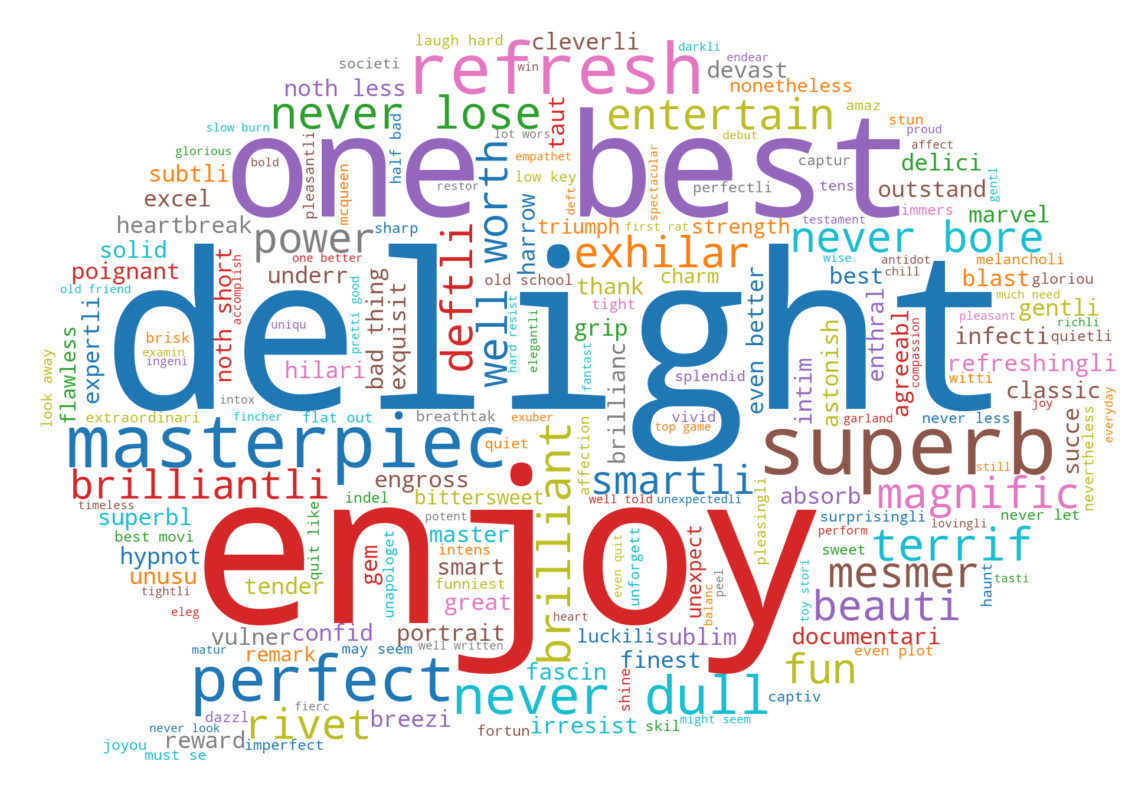

In [83]:
# convert word_counts df to a dictionary
d = word_counts.to_dict()

#import image for word cloud shape
mask_r = np.array(Image.open('data/comment_r.png'))

# plot positive wordcloud of top coefficient values
wordcloud = WordCloud(background_color = 'white', colormap = 'tab10', mask = mask_r, random_state = 1)
wordcloud.generate_from_frequencies(frequencies=d['coefficients'])
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The above wordcloud shows that the words most indicative of a positive review are **delight** and **enjoy**, with the image also showing a number of other words (and two word phrases) that would also be expected to be included in a positive review. The image is then saved locally to be used in documentation later.

In [84]:
# save as an image
wordcloud.to_file('data/positive.png')

The same methodology is used to create a word cloud for negative reviews, where by reversing the scale of the coefficients will allow for the words with the highest negative coefficients to be plotted the largest. This is carried out below.

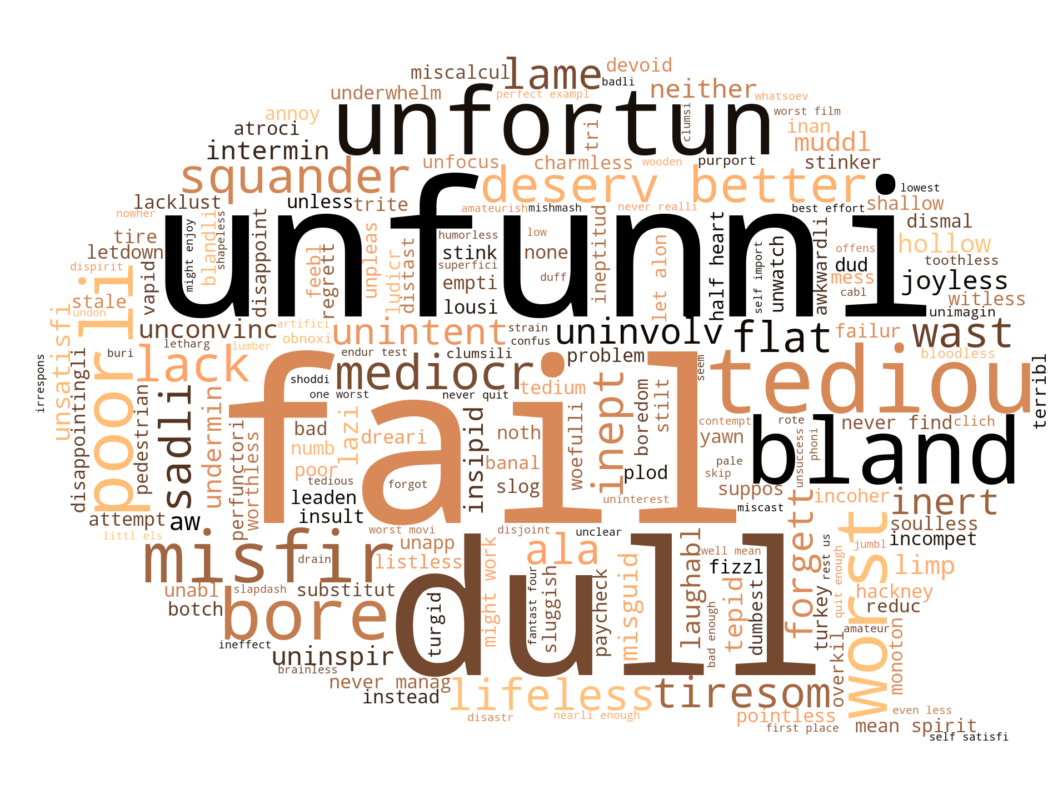

In [68]:
# reverse scaling of coefficients
freq_n = d['coefficients']
keys = list(freq_n.keys())
values = list(freq_n.values())
values.reverse()
freq_n = dict(zip(keys, values))

#import image for word cloud shape
mask_l = np.array(Image.open('data/comment_l.png'))

# define wordcloud
wordcloud_n = WordCloud(random_state = 12, background_color = 'white', colormap = 'copper', mask = mask_l)
wordcloud_n.generate_from_frequencies(frequencies=freq_n)

plt.figure(figsize = (15,10))
plt.imshow(wordcloud_n, interpolation="bilinear")
plt.axis("off")
plt.show()

The above wordcloud indicates that the words most indicative of a negative review are **fail** and **unfunni**, which is a stemmed word taking into account all the varieties of unfunny, unfunniest etc. As before, the images has been saved locally below.

In [69]:
# save as an image
wordcloud_n.to_file('data/negative.png')

The model can now be saved in a **.pkl** file and used alongside the previously mentioned function in order to predict the sentiment of a review. The file is generated below.

In [72]:
from sklearn.pipeline import make_pipeline
import joblib

In [73]:
# turn into a pipeline
sentiment_pipe = make_pipeline(tfidf, tf_logreg)

joblib.dump(sentiment_pipe, "flask/sentiment_pipe.pkl")

['flask/sentiment_pipe.pkl']

This pipeline model can now be used directly with a text input in orde to predict whether the text has a 'Rotten' (class 0) or 'Fresh' (class 1) sentiment, where the pipeline will output an array of probabilities that the review belongs in either class.

An example of this in action is shown below.

In [74]:
sentiment_pipe.predict_proba({'This is the worst'})

array([[0.95181475, 0.04818525]])

The above means that the review input *'This is the worst'* has a 95% probability of belonging to class 0, i.e. Rotten. This is incorporated into a function below.

In [135]:
def review_sentiment(review):

    """
    This function is used evaluate the sentiment of a given review.
    The purpose of this function is to run the review through the optimised sentiment pipeline, then depending on the
    result output whether the review is 'Fresh' or 'Rotten'.
    
    Parameters:
    -----------
    
    review: Full text of a review.
            
    Returns:
    -------
    
    result: Decision on whether the review is 'Fresh' or 'Rotten'
    
    
    """
  
    # import review into pipeline
    model_result = sentiment_pipe.predict_proba({review})
      
    # define result as either 'Fresh' or 'Rotten'
    if model_result.argmax() == 0:
        result = 'This is a \033[1mRotten\033[0;0m review!'
    else:
        result = 'This is a \033[1mFresh\033[0;0m review!'

    return print(result)

Further examples are then investigated to evaluate the sentiment prediction.

In [136]:
review_sentiment('Thanks, I hate it!')

This is a Rotten review!


In [137]:
review_sentiment('This was absolutely the best movie I have ever seen, not sure it can ever be beaten')

This is a Fresh review!


In [138]:
review_sentiment('This was absolutely not the best movie I have ever seen, sure it can be beaten')

This is a Rotten review!


# 9 Next Steps
The file generated above can now be used within a **Streamlit App**, where the sentiment of a given review will be predicted to be either 'Fresh' or 'Rotten'. 

With the completion of the Sentiment Analysis, the Recommender Systems are generated in the remaining two notebook files:
- Content Based Recommender System
- User Based & Collaborative Recommender System